<a href="https://colab.research.google.com/github/ccsed/ProgettoLabAI/blob/main/File1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Collego colab a google drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importo le librerie necessarie

In [3]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 45.8 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt
import random
import skimage.io as io
from rasterio.plot import show

gpu

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Creo la funzione per dividere il dataset in train, validation e test

In [5]:
def split_dataset(image_dir, drive_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=42):
  images = sorted(os.listdir(image_dir))

  combined = [(img, img) for img in images]
  random.seed(seed)
  random.shuffle(combined)

  train_split = int(len(combined) * train_ratio)
  val_split = int(len(combined) * (train_ratio + val_ratio))
  train_data = combined[:train_split]
  val_data = combined[train_split:val_split]
  test_data = combined[val_split:]

  with open(os.path.join(drive_dir, 'train.txt'), 'w') as f:
    for img, lbl in train_data:
      s = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/' + img
      f.write(f"{s} {s}\n")

  with open(os.path.join(drive_dir, 'val.txt'), 'w') as f:
    for img, lbl in val_data:
      s = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/' + img
      f.write(f"{s} {s}\n")


  with open(os.path.join(drive_dir, 'test.txt'), 'w') as f:
    for img, lbl in test_data:
      s = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/' + img
      f.write(f"{s} {s}\n")


Definisco la directory dove salvare i file txt e faccio split sul dataset

In [6]:
drive_dir = '/content/drive/MyDrive'
image_dir = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity'
train_path = '/content/drive/MyDrive/train.txt'
val_path = '/content/drive/MyDrive/val.txt'
test_path = '/content/drive/MyDrive/test.txt'

In [7]:
split_dataset(image_dir, drive_dir)

Per visualizzare un'immagine

Image shape: (4, 900, 900)


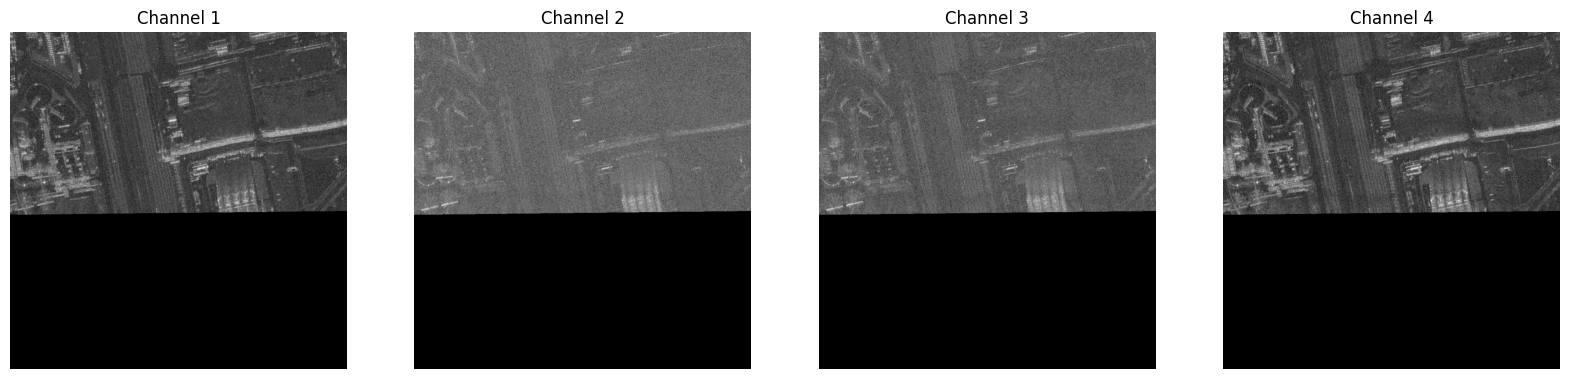

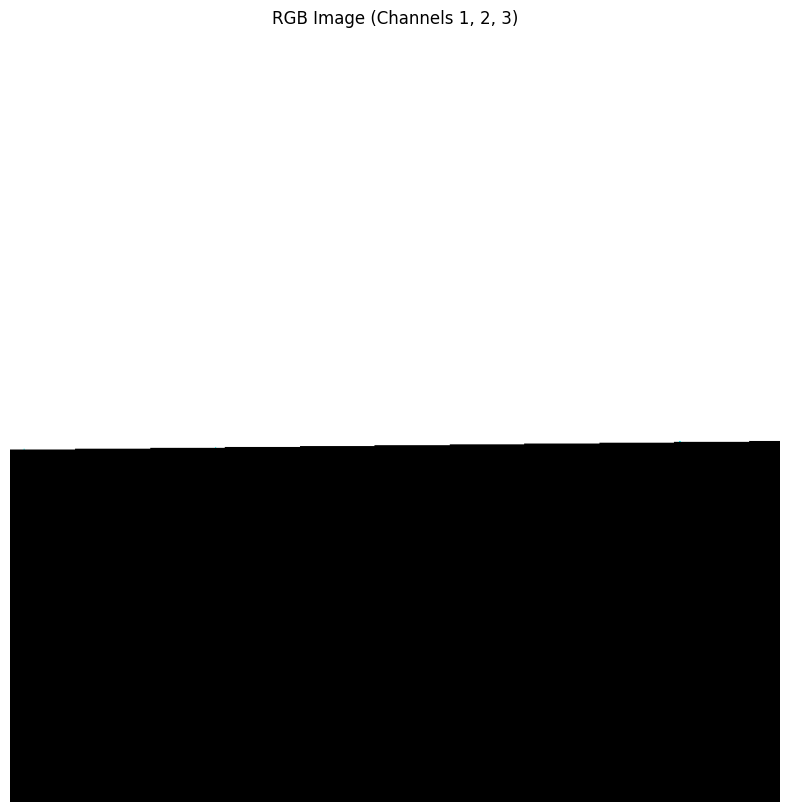

In [8]:
image_path = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804113009_20190804113242_tile_4800.tif'
with rasterio.open(image_path) as src:
  image = src.read()
  print(f"Image shape: {image.shape}")
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
  axs[i].imshow(image[i], cmap='gray')
  axs[i].set_title(f'Channel {i+1}')
  axs[i].axis('off')
plt.show()
rgb_image = image[:3, :, :].astype(float)

rgb_image = rgb_image.transpose((1, 2, 0))

plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title('RGB Image (Channels 1, 2, 3)')
plt.axis('off')
plt.show()

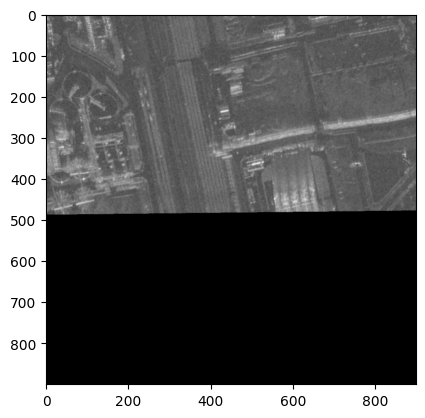

<Axes: >

In [9]:
def normalize(image):
    """
    Normalizza l'immagine in modo che i valori dei pixel siano compresi tra 0 e 1.
    """
    image = image.astype(np.float32)
    image /= image.max()
    return image

def median_filter(image, kernel_size=3):
    """
    Applica un filtro mediano all'immagine per ridurre il rumore.
    """
    from scipy.ndimage import median_filter
    image_filtered = median_filter(image, size=kernel_size)
    return image_filtered

# Carica un'immagine SAR con Rasterio
with rasterio.open(image_path) as src:
    sar_image = src.read()  # Carica l'immagine
    sar_image = np.moveaxis(sar_image, 0, -1)  # Reordina gli assi per PIL-style (H, W, C)

# Esempio di utilizzo delle funzioni di preprocessing
sar_image_normalized = normalize(sar_image)
sar_image_filtered = median_filter(sar_image_normalized, kernel_size=3)

# Visualizza l'immagine preprocessata
sar_image_grayscale = np.mean(sar_image_filtered, axis=-1)

# Visualizza l'immagine preprocessata in scala di grigi
show(sar_image_grayscale, cmap='gray')

Definiamo la classe SARDataset

In [10]:
class SARDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = self.load_image(image_path)
        if self.transform:
            image = self.transform(image)
        return image

    def load_image(self, image_path):
        print(f"Trying to load image: {image_path}")
        try:
            with rasterio.open(image_path) as src:
                image = src.read()
                image = image.astype('float32')
                image = np.transpose(image, (1, 2, 0))  # Cambia l'ordine delle dimensioni a (altezza, larghezza, canali)
            return image
        except Exception as e:
            print(f"Errore nel caricamento dell'immagine {image_path}: {e}")
            raise

Carico i percorsi delle immagini per il training, il validation e il test set

In [17]:
with open(train_path, 'r') as f:
    train_data = [line.split() for line in f.read().splitlines()]

train_image_paths = [line[0] for line in train_data]

with open(val_path, 'r') as f:
    val_data = [line.split() for line in f.read().splitlines()]

val_image_paths = [line[0] for line in val_data]

with open(test_path, 'r') as f:
    test_data = [line.split() for line in f.read().splitlines()]

test_image_paths = [line[0] for line in test_data]

Definisco trasformazioni e augmentation

In [12]:
albumentations_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1),
    A.Normalize(mean=(0.0, 0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0, 1.0)),
])

torchvision_transform = transforms.Compose([
    transforms.ToTensor()
])

def albumentations_to_tensor(image):
    augmented = albumentations_transform(image=image)
    return torchvision_transform(augmented['image'])

Creo il dataset

In [24]:
train_dataset = SARDataset(train_image_paths, albumentations_to_tensor)
val_dataset = SARDataset(val_image_paths, albumentations_to_tensor)
test_dataset = SARDataset(test_image_paths, albumentations_to_tensor)

Creo i DataLoader

In [29]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=2,  shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=1)

In [30]:
for batch in train_loader:
    print("Dimensioni del batch di input:", batch.shape)
    break

Trying to load image: /content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity/SN6_Train_AOI_11_Rotterdam_SAR-Intensity_20190804135937_20190804140208_tile_6564.tif


KeyboardInterrupt: 